# Seeing How a Sleep Apnea Detector Works

The goal of this project is to take a dive into a simple 1D convolution neural network able to detect sleep apnea (with a modest accuracy), and attempt to see how it works.

## I. Setup

The data is available [here](https://challengedata.ens.fr/challenges/45).

Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from visualization import N_signals, visualize_signal
from dataloader import load_data
from model import Simple1DCNN_Open
from constants import *

torch.manual_seed(1)
plt.rcParams["figure.figsize"] = (15, 5)


Load the data and preprocess it.

(Here, I do not apply the necessary precautions for a fair evaluation of the model's performance.)

In [2]:
PATH_TO_TRAINING_DATA = "X_train.h5"
PATH_TO_TRAINING_TARGET = "y_train.csv"

x, mask = load_data(PATH_TO_TRAINING_DATA, PATH_TO_TRAINING_TARGET)

print(x.shape, mask.shape)


(396000, 8, 100) (396000,)


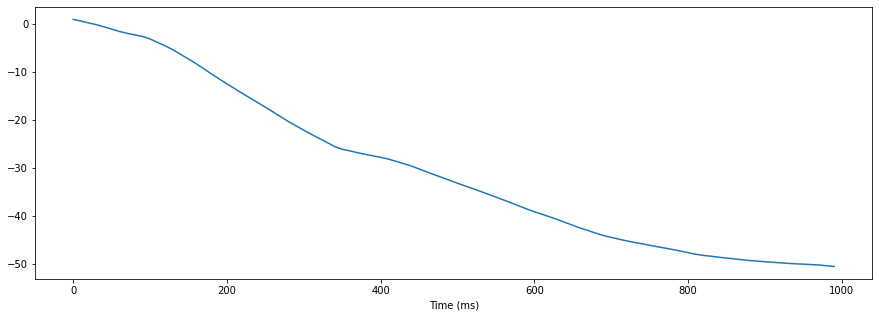

In [3]:
# Visualize the first channel of one random data point during its full duration
channel = 1
plt.plot(np.arange(0, 1000, 10), x[42, channel, :])
plt.xlabel("Time (ms)")
plt.show()


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    x, mask, test_size=0.2, random_state=1
)


In [5]:
means = X_train.mean(axis=0).mean(axis=1)
stds = X_train.std(axis=0).mean(axis=1)


In [6]:
def normalize(X):
    return (X - means[None, :, None]) / stds[None, :, None]


In [7]:
X_train = normalize(X_train)
X_val = normalize(X_val)


Load the dataset

In [8]:
dataset_train = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
dataset_val = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

training_generator = DataLoader(dataset_train, batch_size=64, shuffle=True)
validation_generator = DataLoader(dataset_val, batch_size=64, shuffle=False)


Create the neural network

In [9]:
model = Simple1DCNN_Open()

print(
    "Number of parameters of the network:",
    sum(param.numel() for param in model.parameters()),
)


Number of parameters of the network: 1011


Train the model

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

max_epochs = 20

for epoch in range(max_epochs):
    train_losses = []
    for x, y in tqdm(training_generator, total=len(training_generator)):
        model.zero_grad()

        # Make predictions
        y_pred = model(x)

        # Compute Loss
        loss = criterion(y_pred, y)
        train_losses.append(loss.item())

        # Perform backpropagation
        loss.backward()
        optimizer.step()

    val_losses = []
    with torch.no_grad():
        for x, y in validation_generator:
            # Make predictions
            y_pred = model(x)

            # Compute Loss
            loss = criterion(y_pred, y)
            val_losses.append(loss.item())

    print(
        f"Epoch {epoch+1}: train: {sum(train_losses)/len(train_losses):.4f} val: {sum(val_losses)/len(val_losses):.4f}"
    )


100%|██████████| 4950/4950 [00:22<00:00, 221.63it/s]


Epoch 1: train: 0.2218 val: 0.2136


100%|██████████| 4950/4950 [00:22<00:00, 223.47it/s]


Epoch 2: train: 0.2139 val: 0.2133


100%|██████████| 4950/4950 [00:22<00:00, 219.66it/s]


Epoch 3: train: 0.2120 val: 0.2108


100%|██████████| 4950/4950 [00:23<00:00, 212.09it/s]


Epoch 4: train: 0.2108 val: 0.2089


100%|██████████| 4950/4950 [00:21<00:00, 225.61it/s]


Epoch 5: train: 0.2098 val: 0.2076


100%|██████████| 4950/4950 [00:21<00:00, 230.26it/s]


Epoch 6: train: 0.2089 val: 0.2060


100%|██████████| 4950/4950 [00:21<00:00, 230.34it/s]


Epoch 7: train: 0.2070 val: 0.2045


100%|██████████| 4950/4950 [00:20<00:00, 235.82it/s]


Epoch 8: train: 0.2042 val: 0.2016


100%|██████████| 4950/4950 [00:21<00:00, 231.76it/s]


Epoch 9: train: 0.2027 val: 0.2008


100%|██████████| 4950/4950 [00:21<00:00, 232.47it/s]


Epoch 10: train: 0.2017 val: 0.2005


100%|██████████| 4950/4950 [00:20<00:00, 236.61it/s]


Epoch 11: train: 0.2009 val: 0.2015


100%|██████████| 4950/4950 [00:21<00:00, 235.58it/s]


Epoch 12: train: 0.2003 val: 0.1974


100%|██████████| 4950/4950 [00:22<00:00, 222.15it/s]


Epoch 13: train: 0.1998 val: 0.1987


100%|██████████| 4950/4950 [00:21<00:00, 226.43it/s]


Epoch 14: train: 0.1992 val: 0.1976


100%|██████████| 4950/4950 [00:20<00:00, 241.05it/s]


Epoch 15: train: 0.1985 val: 0.1976


100%|██████████| 4950/4950 [00:19<00:00, 250.96it/s]


Epoch 16: train: 0.1982 val: 0.1971


100%|██████████| 4950/4950 [00:22<00:00, 220.79it/s]


Epoch 17: train: 0.1975 val: 0.1968


100%|██████████| 4950/4950 [00:19<00:00, 248.20it/s]


Epoch 18: train: 0.1972 val: 0.1973


100%|██████████| 4950/4950 [00:20<00:00, 240.44it/s]


Epoch 19: train: 0.1965 val: 0.1953


100%|██████████| 4950/4950 [00:20<00:00, 238.14it/s]


Epoch 20: train: 0.1963 val: 0.1945


Evaluate the model's performance

In [11]:
with torch.no_grad():
    y_val_pred = model(torch.FloatTensor(X_val)).numpy()
y_val_pred_bit = np.where(y_val_pred >= 0.3, 1, 0)
val_f1 = f1_score(y_val, y_val_pred_bit)
print(f"f1 score: {val_f1}")


f1 score: 0.35271032622026


Extract the activations of the network during the forward pass

In [12]:
with torch.no_grad():
    _, extracted_torch = model(torch.tensor(X_val).float(), True)
    extracted = [tensor.numpy() for tensor in extracted_torch]
    extracted = [
        array.sum(-1) if i < len(extracted) - 1 else array
        for i, array in enumerate(extracted)
    ]
print([array.shape for array in extracted])


[(79200, 8), (79200, 10), (79200, 10), (79200,), (79200, 1)]


## 2. Visualize examples according to their activations 

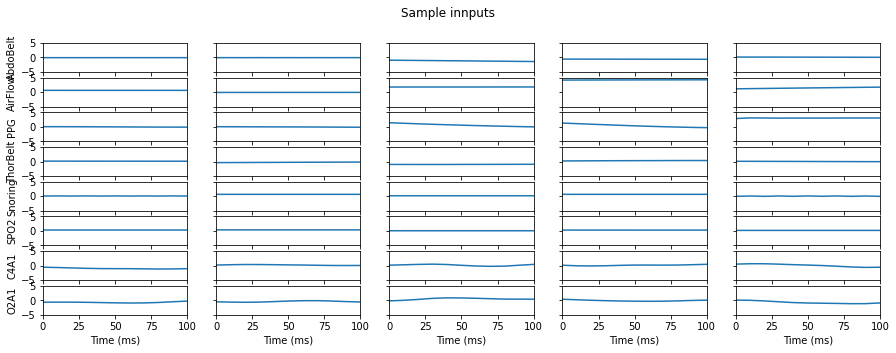

In [31]:
visualize_signal(X_val, np.random.choice(X_val.shape[0], 5), title="Sample innputs")


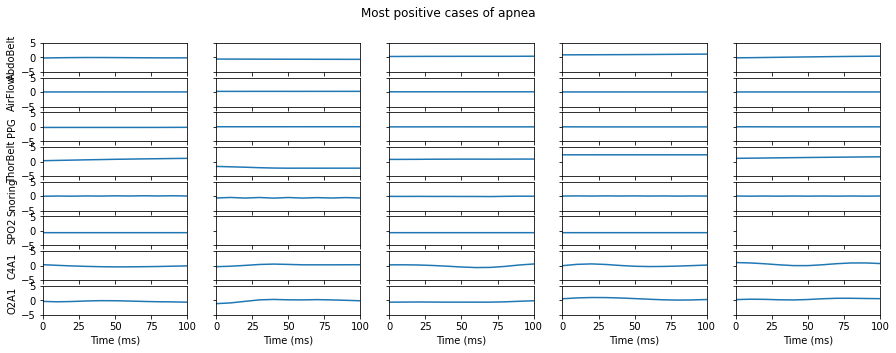

In [32]:
last_neurons_activations = extracted[-1][:, 0]
mostActivated = [(val, i) for i, val in enumerate(last_neurons_activations)]
mostActivated.sort(reverse=True)

visualize_signal(
    X_val, [mostActivated[i][1] for i in range(5)], title="Most positive cases of apnea"
)


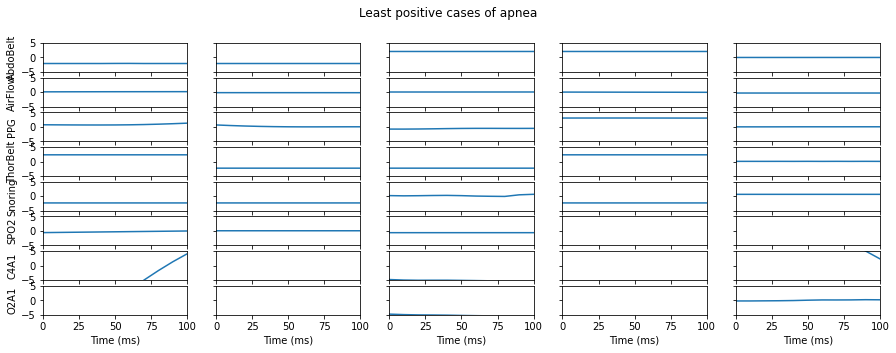

In [33]:
visualize_signal(
    X_val,
    [mostActivated[-i - 1][1] for i in range(5)],
    title="Least positive cases of apnea",
)


As we might have guessed, the model associates sleep apnea with abnormal values in EEG signals (O2A1 and C4A1).

Let's go a bit deeper, and visualize some maximum and minimum activation of a neuron in the middle of the network

In [34]:
neuron_1_0_activations = extracted[2][:, 1]
mostActivated = [(val, i) for i, val in enumerate(neuron_1_0_activations)]
mostActivated.sort(reverse=True)


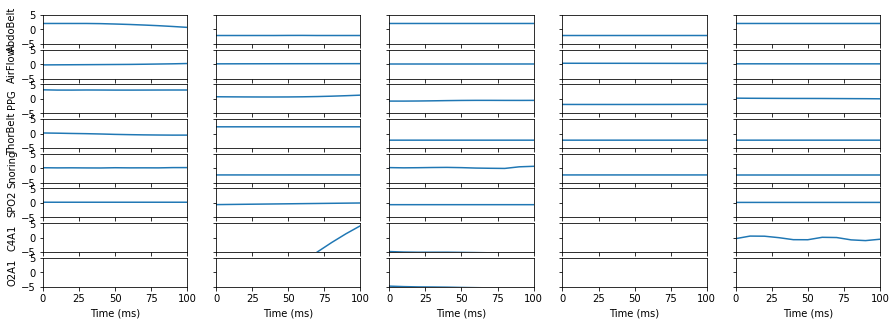

In [35]:
visualize_signal(X_val, [mostActivated[i][1] for i in range(5)])


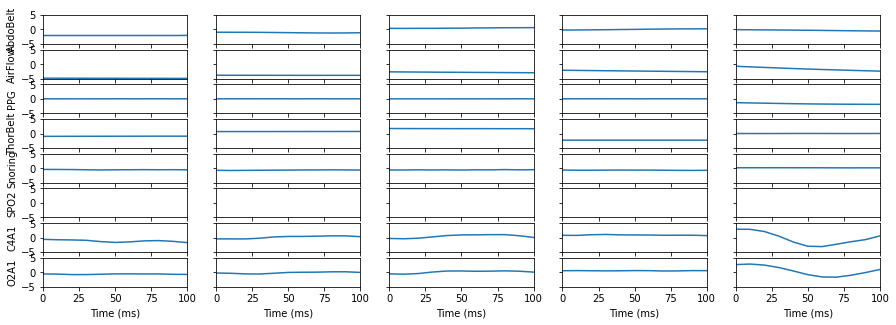

In [36]:
visualize_signal(X_val, [mostActivated[-i - 1][1] for i in range(5)])


Not being a specialist, we can make a few guesses but no general conclusions.

## Visualizing the weights

The network being so small, it isn't too hard to look directly at the weights.

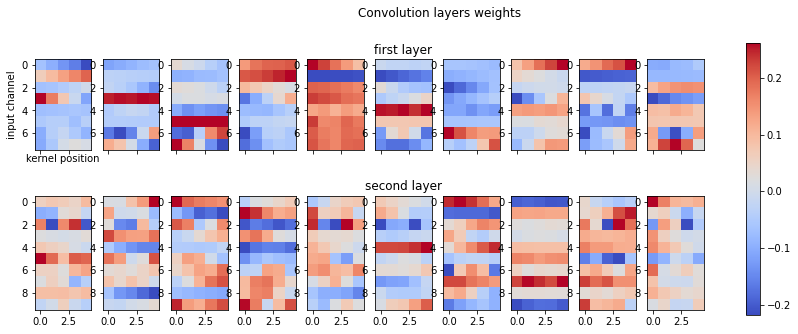

In [37]:
fig, axs = plt.subplots(2, 10, sharex=True, sharey=False)
for i in range(2):
    for j in range(10):
        weights = model.conv_layers[i].conv1d.weight[j, :, :].detach().numpy()
        pcm = axs[i, j].imshow(weights, cmap="coolwarm")
fig.colorbar(pcm, ax=axs[:, :])

axs[0, 0].set_xlabel("kernel position")
axs[0, 0].set_ylabel("input channel")

axs[0, 5].set_title("first layer")
axs[1, 5].set_title("second layer")

fig.suptitle("Convolution layers weights")

plt.show()


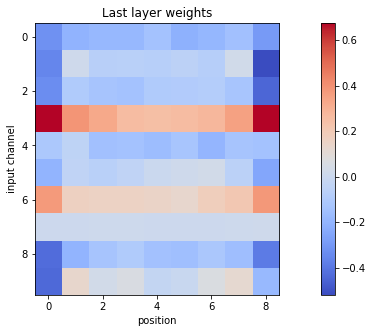

In [38]:
weights = model.final_lin.weight.detach().numpy().reshape((-1, 9))
plt.imshow(weights, cmap="coolwarm")
plt.colorbar()
plt.title("Last layer weights")
plt.xlabel("position")
plt.ylabel("input channel")
plt.show()


The network seems to extract information through a simple linear function of the average of the layers below (weighted by the proximity of the associated inputs to the borders: they might be more information dense by providing information about events surounding the recorded sequence).

A high activation of channel 3 in the last layer seems to lead to high confidence in sleep apnea. Let's see if that makes sense.

Such a high activation is caused by low activation in channels 2 and 4 of the previous layer and a decreasing activation in channel 1.

* Low activation in channel 2, means low activation of channel 5 (O2 saturation of the blood), which makes sense + some obscur effects with EEGs (decrease in the 6th channel, increase of the 7th channel).
* Low activation in channel 4 means high channel 2 activation (airflow) compared to the rest of the activations, which also makes sense, though it is not straightforward (if airflow is high, but the other activation are low, it might indicate that the patient is over-ventilating?)
* Decreasing activation in channel 1 means that the decrease in channel 3 (Record Thoracic contraction) is decreasing, which might make sense if we consider the fact that it could be the thoracic contraction are reaching a stable low level.

This gives an idea of what to consider, but is by no mean a complete account of the inner workings of the system.

## Creating inputs maximizing the activations

Here we maximize and minimize the activations of the first neuron of each layer.

In [56]:
from torch.autograd import Variable

n_tests = 3
# Variable 2*i corresponds to maximizing the activation of neuron 0 in layer i
# Variable 2*i+1 corresponds to minimizing the activation of neuron 0 in layer i
fake_signals = Variable(torch.rand(2 * n_tests, N_signals, 100), requires_grad=True)
layers = list(range(3))
neurons = [0] * 3


Creating 

In [57]:
signal_optimizer = optim.Adam([fake_signals], lr=0.0005)

max_epochs = 10

for epoch in range(max_epochs):
    for iter in range(1000):
        signal_optimizer.zero_grad()
        loss = 0
        # Make predictions
        y_pred, activations = model(fake_signals, True)

        # Compute Loss
        for i in range(n_tests):
            positive_activation = activations[layers[i]][2 * i, neurons[i], :]
            negative_activation = activations[layers[i]][2 * i + 1, neurons[i], :]
            # Negative activation should be minimized
            loss += negative_activation.mean()
            # Positive action should be maximized
            loss += -positive_activation.mean()
        # Penalize inputs with very high or low values
        loss += (fake_signals[:, :] ** 2).mean(dim=1).sum()

        # Perform backpropagation
        loss.backward()

        signal_optimizer.step()

    print(f"Loss at epoch {epoch}: {loss.item():.2f}")


Loss at epoch 0: 39.66
Loss at epoch 1: 4.62
Loss at epoch 2: -0.01
Loss at epoch 3: -0.23
Loss at epoch 4: -0.23
Loss at epoch 5: -0.23
Loss at epoch 6: -0.23
Loss at epoch 7: -0.23
Loss at epoch 8: -0.23
Loss at epoch 9: -0.23


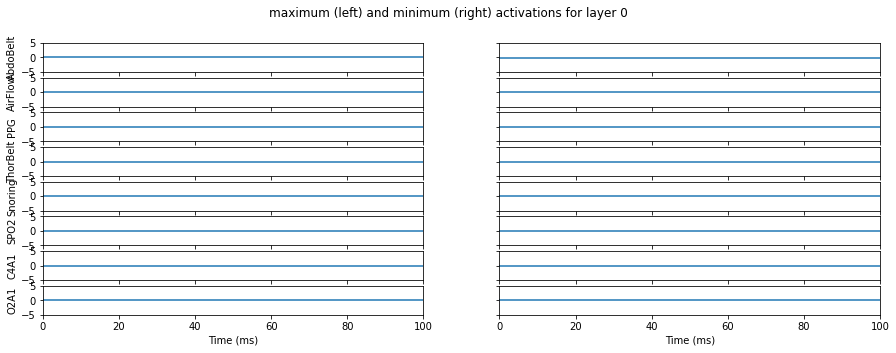

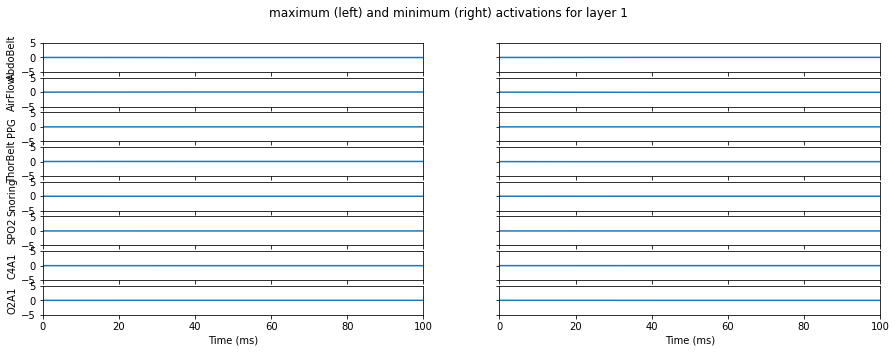

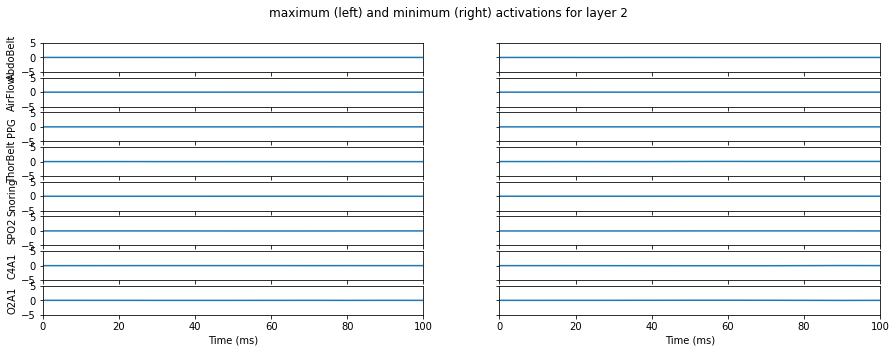

In [58]:
for i in range(n_tests):
    visualize_signal(
        fake_signals[2 * i : 2 * i + 2].detach().numpy(),
        [0, 1],
        title=f"maximum (left) and minimum (right) activations for layer {i}",
    )


The input being not very human readable, this isn't very useful at first glance. It might be a bit more useful if we added some kind of normalization to make it stick to the original distribution of data.